# Preconfiguring the IDE (Предварительная настройка среды разработки)

## Installing the required libraries (Установка необходимых библиотек)

In [ ]:
! pip install ffmpeg
! pip install moviepy
! pip3 install imageio==2.4.1
! pip install pytube
! pip install git+https://github.com/openai/whisper.git -q
! pip3 install transformers[sentencepiece]
! pip install sacremoses
! pip install evaluate
! pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 4.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=dfd64931efe811a5cbd629e5ab486f9942b4575bb76970f57e735064579a68f7
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https:/

Для локальной среды разработки:

In [ ]:
# ! conda install -y -c conda-forge ffmpeg
# ! conda install -y -c conda-forge moviepy
# ! conda install -y -c conda-forge imageio==2.4.1
# ! conda install -y -c conda-forge pytube
# ! conda install -y -c huggingface transformers
# ! conda install -y -c conda-forge pydub
# ! conda install -y -c conda-forge sentencepiece

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found


## Importing necessary libraries (Импорт необходимых библиотек)

In [ ]:
# Вспомогательные бибилотеки
import os
import multiprocessing
from pprint import pprint
import gc
from tqdm import tqdm


# Обработка видео
import moviepy.editor

# Работа с данными
import pandas as pd

# Загрузка видео с Youtube
from pytube import YouTube

# Whisper
import whisper

# Pytorch
import torch

# HuggingFace
import sentencepiece as spm
from transformers import pipeline
from evaluate import load

# Pandas
import pandas as pd
import numpy as np


## Setting up the development environment (Настройка среды разработки)

In [ ]:
# Определим наличие графического ускорителя. Если доступен - используем.
detected_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current PyTorch device is set to", detected_device)

# Количество рабочих процессов, зависи от CPU
system_num_workers = multiprocessing.cpu_count()
print("The number of workers processes is set at", system_num_workers)

Current PyTorch device is set to cuda:0
The number of workers processes is set at 2


## Checking video card availability (Проверка доступности видеокарты)

In [ ]:
!nvidia-smi

Sun Dec 25 14:48:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   1838MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Auxiliary functions (Вспомогательные функции)

In [ ]:
# Функция для скачивание видео c Youtube по ссылке
# Если доступны субтитры на английском, то они тоже будут загруженны.
def download_youtube_video(url):

  result = {"video_path":[],
            "subtitles_official_en_path":[]}

  # Получим название видео
  youtubeObject = YouTube(url)
  video_title = youtubeObject.title

  # Создадим папку для хранения видео
  path = os.path.join("./", video_title)
  os.mkdir(path)

  # Сохраним путь к файлам видео
  result["folder_path"] = path

  # Сохраним субтитры на американском английском (если они есть)
  subtitle_path = path + "/subtitles_orig_en.xml"
  try:
    subtitles = youtubeObject.captions['en-US'].xml_captions
    with open(subtitle_path, "w") as subtitles_file:
      subtitles_file.write(subtitles)
    
    result["subtitles_official_en_path"] = subtitle_path
  except Exception as e:
    print("An error has occurred while saving subtitles.", str(e))

  # Скачаем видео
  video_path = path + "/video.mp4"
  try:
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    youtubeObject.download(filename=(video_path))
    # youtubeObject.streams.filter(res="1080p", file_extension='mp4').first().download(filename=(path + "/video.mp4"))

    result["video_path"] = video_path
  except Exception as e:
    print("An error has occurred while saving video.", str(e))
    return result

  print("Download is completed successfully")
  return result


# Извлечение аудиодорожки из видеофайла
def extract_audio_track(video_file_path, audio_file_path):
  try:
    video = moviepy.editor.VideoFileClip(video_file_path)

    audio = video.audio

    # Сохраняем аудио в mp3 формате, моно, 16Khz
    audio.write_audiofile(audio_file_path, fps=16000, progress_bar=True, ffmpeg_params=["-ac", "1"])
  except:
    print("Can't extract audio from videofile.")
    return audio_file_path

  return audio_file_path


# Преобразуем строку в список без удаления символа-сепаратора
def make_sentences(text, delimiter):

  # Уберем из текста символы начала строки
  text = text.replace("\n"," ")
  
  # Разделим текст на предложения без удаления точек.
  sentences = [sentence + delimiter for sentence in text.split(delimiter) if sentence]
  return sentences


# Инференс модели, возвращает вывод модели содержащий субтитры
def model_inf(model_name, audio_path, language="en"):
  try:
    # В процессе загрузки модели происходит автомматическое определение наличия 
    # ускорителя. Преимущественно модель загружается на GPU иначе - CPU
    # https://github.com/openai/whisper/blob/main/whisper/__init__.py
    model = whisper.load_model(model_name)

    result = model.transcribe(audio_path, language=language)
    return result
  
  except Exception as e:
    print("An exception occurred during the model inference.", str(e))


# Обработка вывода модели, подготовка датафрейма с данными
def create_subtitles_df(model_output):
  try:

    # Преобразуем вывод модели в датафрейм
    df = pd.DataFrame.from_records(model_output["segments"], index="id")

    # Конвертируем индерс в номер строки
    df['subtitle_num'] = df.index

    # Удалим лишние столбцы
    df = df.drop(['tokens', 
                  'temperature', 
                  'avg_logprob',
                  'compression_ratio', 
                  'no_speech_prob',
                  'seek'], axis=1)

    # Добавим сепаратор временных меток и поменяем порядок столбцов
    df['timestamp_separator'] = '-->'

    # Зададим корректный формат временных меток
    df["start"] = pd.to_datetime(df["start"], unit='s')
    df["start"] = df["start"].dt.strftime('%H:%M:%S.000')     # Обрежим миллисекунды

    df["end"] = pd.to_datetime(df["end"], unit='s')
    df["end"] = df["end"].dt.strftime('%H:%M:%S.000')         # Обрежим миллисекунды

    # Соберем столбец временных меток для субтитров
    df["timestamps"] = df["start"] + " " + df["timestamp_separator"] + " " + df["end"]

    # Зададим порядок столбцов
    columns_order = ['subtitle_num', "timestamps", 'text']
    df = df[columns_order]

    return df

  except Exception as e:
    print("An exception occurred during the creation of a dataframe with subtitles.", str(e))


# Сохранение датафрейма с субтитрами в формате STR
def save_to_str(df, work_folder, file_name):
  # Путь для сохранения файла со сгенерированными субтитрами
  subtitles_path = work_folder + file_name 

  np.savetxt(subtitles_path, 
             df.values, 
             delimiter='\n', 
             fmt="%s")

  return subtitles_path

# Global script parameters (Глобальные параметры скрипта)

In [ ]:
# Ссылка на видео с YouTube

youtube_link = "https://youtu.be/P127jhj-8-Y"                     # Семинар Стенфорда
# youtube_link = "https://www.youtube.com/watch?v=ZKk_UMo275s"    # Длинный семинар Стенфорда
# youtube_link =  "https://youtu.be/wEIzkUf-QZs"                  # Игровое видео с большим количеством шума

# Description of the problem area (Описание проблемной области)

Большинство современных курсов по машинному и глубокому обучению выкладывается в YouTube. Но часто эти курсу:    
1) озвученны на языке носителя (английском)    
2) не имеют русских субтитров    

Цель моей работы - создание русских субтитров к видео с YouTube.

У данной задачи есть особенности:

1) В частности применение метрик для оценки качества модели ASR затруднительно по причине отсутствия полной транскрибации (перевода аудиоматериала в текстовую информацию). Яркий пример подобной ситуации часто встречается в лекциях различных универсистетов - вопросы задаваемые студентами курсов не всегда транскрибируются (в основном транскрибируют голос лектора). Таким образом использование метрик оценки качества не даёт точный результат. То есть, с помощью той же метрики WER мы узнает насколько различаются официальные субтитры с полученными нами в процессе транскрибации. А не насколько точно мы транскрибировали аудио. Кроме того, у видео может и не быть субтитров вообще. Либо они могут быть сгенерированны автоматически (что тоже может внести ошибки в зависимости от их качества).

# Loading data (Загрузка данных)

Выберем видео на YouTube и сохраним его локально:

In [ ]:
files = download_youtube_video(youtube_link)
pprint(files)

Download is completed successfully
{'folder_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
                'that have revolutionized NLP, CV, RL',
 'subtitles_official_en_path': './CS25 I Stanford Seminar - Transformers '
                               'United: DL Models that have revolutionized '
                               'NLP, CV, RL/subtitles_orig_en.xml',
 'video_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
               'that have revolutionized NLP, CV, RL/video.mp4'}


На данном этапе данные представялют из себя 3 файла:    
- 'video.mp4' - сам ролик на английском языке со звуковой дорожкой
- 'subtitles.xml' - официальные субтитры к видео (если они есть и не сгенерированны автоматически).
- 'audio.mp3' - извлеченная звуковая дорожка к видео

# Data augmentation (Аугментация данных)

> ***ВАЖНО! Модель корректно генерирует субтитры только для следующих форматов аудио файлов: `flac`, `mp3`, `wav`. В случае других форматов возникают проблемы с корректностью временныых меток. Подробнее можно прочитать [здесь](https://github.com/openai/whisper)***

Извлечем из видео звуковую дорожку.

In [ ]:
files["audio_path"] = extract_audio_track(files['video_path'], files["folder_path"] + "/audio.mp3")
pprint(files)

[MoviePy] Writing audio in ./CS25 I Stanford Seminar - Transformers United: DL Models that have revolutionized NLP, CV, RL/audio.mp3


100%|██████████| 10906/10906 [00:09<00:00, 1126.21it/s]

[MoviePy] Done.
{'audio_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
               'that have revolutionized NLP, CV, RL/audio.mp3',
 'folder_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
                'that have revolutionized NLP, CV, RL',
 'subtitles_official_en_path': './CS25 I Stanford Seminar - Transformers '
                               'United: DL Models that have revolutionized '
                               'NLP, CV, RL/subtitles_orig_en.xml',
 'video_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
               'that have revolutionized NLP, CV, RL/video.mp4'}


# Subtitle generation (Генерация субтитров)

Сгенерируем субтитры используя модель Whisper. Выбор модели обусловлен тем, что данная модель так же хороше расставляет пукнктуацию. Все остальные проверенные модели возвращают текст без пунктуации заглавными буквами.

In [ ]:
transcribing_model = "medium.en"
model_output = model_inf(model_name=transcribing_model, 
                         audio_path=files['audio_path'],
                         language="en")

gc.collect()

100%|█████████████████████████████████████| 1.42G/1.42G [00:25<00:00, 59.9MiB/s]


456

Создадим датафрейм с субтитрами из полученного вывода модели:

In [ ]:
subtitles_df = create_subtitles_df(model_output)
subtitles_df.head()

,subtitle_num,timestamps,text
id,,,
0,0,00:00:00.000 --> 00:00:06.000,Okay.
1,1,00:00:06.000 --> 00:00:13.000,"Hey everyone, welcome to the first and introd..."
2,2,00:00:13.000 --> 00:00:28.000,So CS 25 was a class that the three of us cre...
3,3,00:00:28.000 --> 00:00:43.000,But we have deep learning models and specific...
4,4,00:00:43.000 --> 00:00:54.000,We have an exciting set of videos lined up fo...


Сохраним субтитры в формате STR:

In [ ]:
# Добавим символ переноса строки в конец текста
subtitles_df["text"] = subtitles_df["text"] + "\n"

# Сохранение с использованием NumPy
files["subtitles_generated_en"] = save_to_str(subtitles_df, 
                                              files['folder_path'], 
                                              "/subtitle_gen_en.srt")

# # Сохранение с использованием Pandas
# subtitles_df.to_csv(files["subtitles_generated_en"], 
#                     header=None, 
#                     index=None,
#                     sep="\n")


pprint(files)

{'audio_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
               'that have revolutionized NLP, CV, RL/audio.mp3',
 'folder_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
                'that have revolutionized NLP, CV, RL',
 'subtitles_generated_en': './CS25 I Stanford Seminar - Transformers United: '
                           'DL Models that have revolutionized NLP, CV, '
                           'RL/subtitle_gen_en.srt',
 'subtitles_official_en_path': './CS25 I Stanford Seminar - Transformers '
                               'United: DL Models that have revolutionized '
                               'NLP, CV, RL/subtitles_orig_en.xml',
 'subtitles_translated_ru': './CS25 I Stanford Seminar - Transformers United: '
                            'DL Models that have revolutionized NLP, CV, '
                            'RL/subtitles_translated_ru.srt',
 'video_path': './CS25 I Stanford Seminar - Transformers United: DL Models '
    

# Quality assessment of the ASR model (Оценка качества модели ASR)

***В данном случае метрика демострирует насколько полученные нами субтитры отличаются от официально предоставленных субтитров.***

## Word error rate metric (Метрика Word Error Rate)

Коэффициент ошибок в словах (WER) является общей метрикой эффективности системы автоматического распознавания речи.

Общая сложность измерения эффективности заключается в том, что распознанная последовательность слов может иметь длину, отличную от длины эталонной последовательности слов (предположительно правильной). WER является производной от расстояния Левенштейна, только работает на уровне слов, а не фонем. WER является ценным инструментом для сравнения различных систем, а также для оценки улучшений в рамках одной системы. Однако этот вид измерения не дает подробной информации о природе ошибок перевода, поэтому требуется дальнейшая работа, чтобы определить основной источник (источники) ошибок и сфокусировать исследовательские усилия.

Эта проблема решается путем предварительного выравнивания распознанной последовательности слов с эталонной (разговорной) последовательностью слов с помощью динамического выравнивания строк.

Коэффициент ошибок в словах может быть вычислен как:

$$WER = \frac{S + D + I}{N} = \frac{(S + D + I)}{(S + D + C)}$$

,где:    
S - количество замен,    
D - количество удалений,    
I - количество вставок,    
C - количество правильных слов,    
N - количество слов в эталоне ($N=S+D+C$).   
    
Это значение показывает среднее количество ошибок на одно опорное слово. Чем меньше значение, тем лучше производительность системы ASR, при этом WER, равный 0, является идеальной оценкой.

## Subtitle Difference Estimation (Оценка разницы в субтитрах)

Я специально выбрал видео у которого уже есть официальные английские субтитры. Загрузим их и оценим насколько полученные с помощью модели Whisper субтитры отличаются от предоставленных официально субтитров:

In [ ]:
references = pd.read_xml(files["subtitles_official_en_path"], xpath='./body/*')
references = references.replace('\n',' ', regex=True)                     # Удалим символ переноса строки.
references = [references.p.str.cat(sep=' ')]
references

['Hey, everyone. Welcome to the first and introductory lecture for CS 25, Transformers United. So CS 25 was a class that the three of us created and taught at Stanford in the fall of 2021, and the subject of the class is not as the picture might suggest. It\'s not about robots that can transform into cars. It\'s about deep learning models and specifically a particular kind of deep learning models that have revolutionized multiple fields, starting from natural language processing to things like computer vision and reinforcement learning to name a few. We have an exciting set of videos lined up for you. We had some truly fantastic speakers come and give talks about how they were applying Transformers in their own research. And we hope you will enjoy and learn from these talks. This video is purely an introductory lecture to talk a little bit about transformers. And before we get started, I\'d like to introduce the instructors. So my name is Advay. I am a software engineer at a company ca

Подготовим полученные от модели сибтитрый для расчёта метрики WER:

In [ ]:
subtitles_df['text'] = subtitles_df['text'].str.strip()     # Удалим лишние пробелы в начале и конце строк.
prediction = subtitles_df.text.str.cat(sep=' ')             # Объединим все строки через один символ пробела
prediction = prediction.replace("CS25","CS 25")             # Исправим ошибку трактовки номера курса.
prediction = [prediction]
prediction

["Okay. Hey everyone, welcome to the first and introductory lecture for CS 25 Transformers united. So CS 25 was a class that the three of us created and taught at Stanford in the fall of 2021. And the subject of the class is not as the picture might suggest it's not about robots that can transform into cars. But we have deep learning models and specifically the particular kind of deep learning models that have revolutionized multiple fields, starting from natural language processing to things like computer vision and reinforcement learning to name a few. We have an exciting set of videos lined up for you we have some truly fantastic speakers come and give talks about how they were applying transformers in their own research. So please enjoy and learn from these talks. This video is purely an introductory lecture to talk a little bit about transformers. And before we get started, I'd like to introduce the instructors. So my name is Abhay, I am a software engineer at the company called A

Расчитаем метрику WER:

In [ ]:
wer = load("wer")
wer_score = wer.compute(predictions=prediction, references=references)
wer_score

0.15485126494300805

В целом, полученные в процессе транскрибации субтитры на 15% отличаются от предоставленных официально. НО! По данному показателю сложно сделать конретные выводы, так как нужно учитывать особености задачи изложенные в пункте "Description of the problem area (Описание проблемной области)". Можно сказать, что полученные субтитры на 85% совпадают с официально предоставленными. Не совпавшие 15% это не только ошибки транскрибации, но и извлеченная из аудио дополнительная информация (например, вопросы студентов не  вошедшие в итоговых официальный вариант субтитров).

# Subtitle translation (Перевод субститров)

Так как перевод с английского на другие языки на текущий момент [заблокирован в модели Wisper](https://github.com/openai/whisper/discussions/649). Воспользуемся [другой моделью](https://huggingface.co/Helsinki-NLP/opus-mt-en-ru) для перевода английских субтитров на русский язык:

In [ ]:
translation_model = "Helsinki-NLP/opus-mt-en-ru"
pipe = pipeline("translation", model=translation_model)
rus_subtitle = pipe(subtitles_df["text"].tolist())
subtitles_df["rus_translation"] = (pd.DataFrame(rus_subtitle))["translation_text"]
subtitles_df.head(15)

,subtitle_num,timestamps,text,rus_translation
id,,,,
0,0,00:00:00.000 --> 00:00:06.000,Okay.,Хорошо.
1,1,00:00:06.000 --> 00:00:13.000,"Hey everyone, welcome to the first and introdu...","Привет всем, добро пожаловать на первую и всту..."
2,2,00:00:13.000 --> 00:00:28.000,So CS 25 was a class that the three of us crea...,"Итак, CS 25 был классом, который мы трое созда..."
3,3,00:00:28.000 --> 00:00:43.000,But we have deep learning models and specifica...,"Но у нас есть модели глубокого обучения и, в ч..."
4,4,00:00:43.000 --> 00:00:54.000,We have an exciting set of videos lined up for...,"У нас есть увлекательный набор видеороликов, г..."
5,5,00:00:54.000 --> 00:00:57.000,So please enjoy and learn from these talks.,"Так что, пожалуйста, наслаждайтесь и учитесь н..."
6,6,00:00:57.000 --> 00:01:11.000,This video is purely an introductory lecture t...,"Это видео - всего лишь вводная лекция, чтобы н..."
7,7,00:01:11.000 --> 00:01:15.000,Before this I was a master's student in CS at ...,До этого я был мастером в криминалистике в Стэ...
8,8,00:01:15.000 --> 00:01:20.000,And I am one of the co instructors for CS 25.,И я один из инструкторов 25-й RC.


Судя по представленному выше переводу, качество оставляет желать лучшего. Это не удивительно, ведь использовалась модель тренированная для текстов общего назначения. Это хорошо заметно по переводу слова "transformers" (переведено как "трансформаторы"). На текущий момент подобные проблемы встречаются в большинстве онлайн переводчиков: 

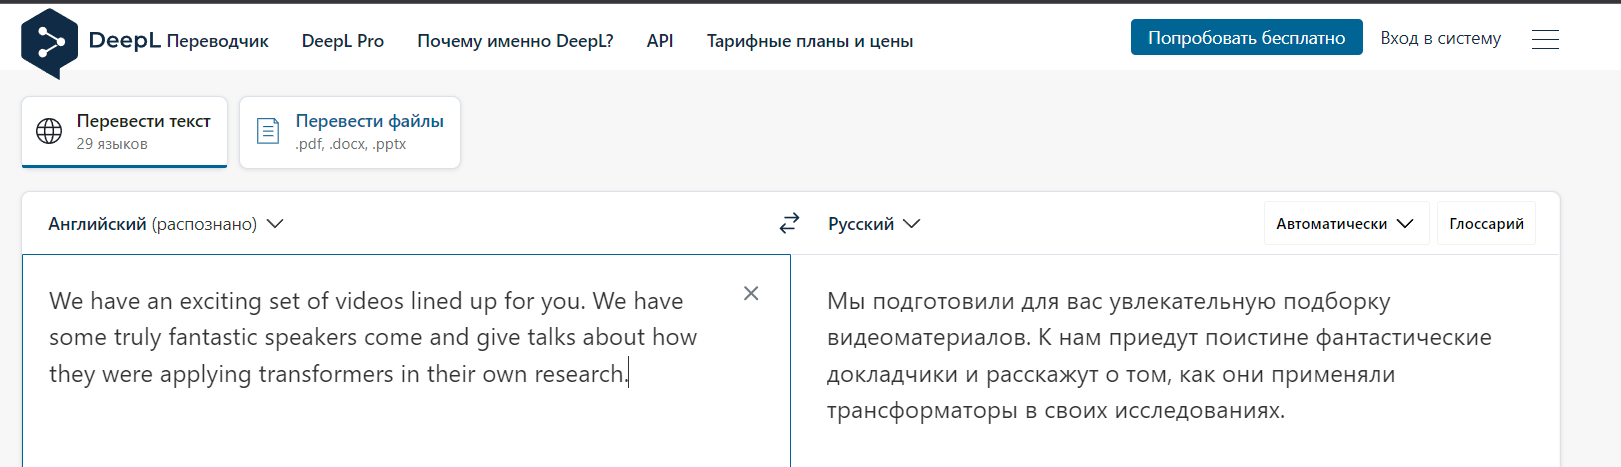

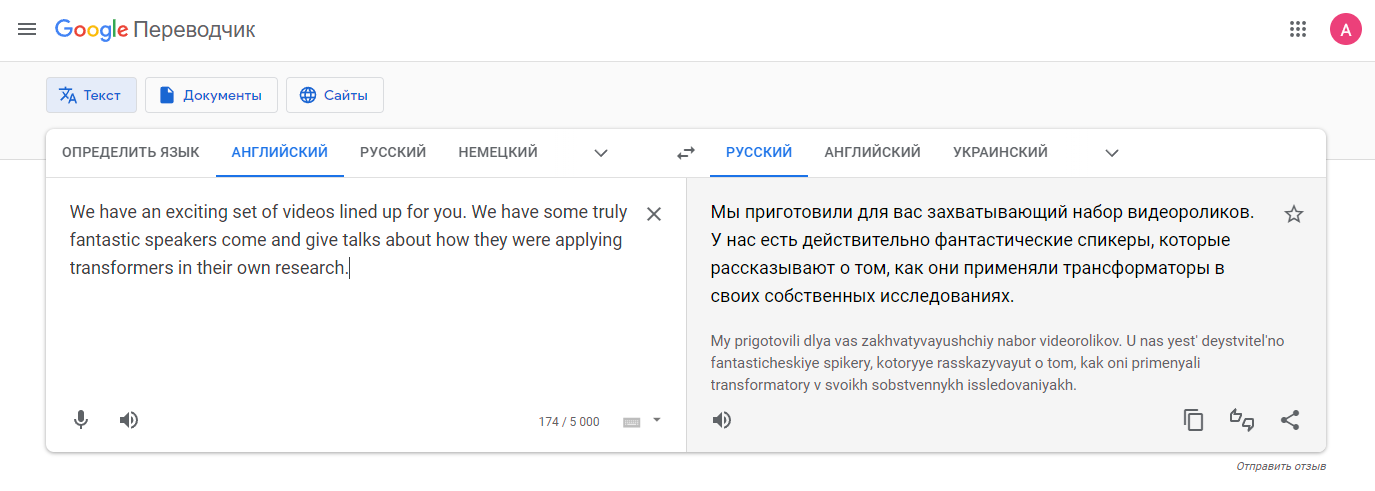

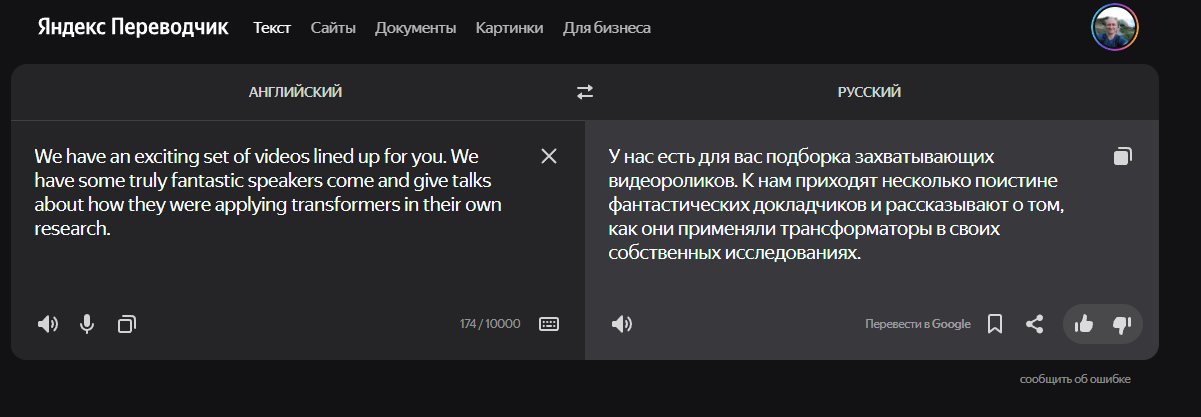

Созраним полученные субтитры в формате STR:

In [ ]:
subtitles_df

,subtitle_num,timestamps,text,rus_translation
id,,,,
0,0,00:00:00.000 --> 00:00:06.000,Okay.\n\n\n,Хорошо.
1,1,00:00:06.000 --> 00:00:13.000,"Hey everyone, welcome to the first and introdu...","Привет всем, добро пожаловать на первую и всту..."
2,2,00:00:13.000 --> 00:00:28.000,So CS 25 was a class that the three of us crea...,"Итак, CS 25 был классом, который мы трое созда..."
3,3,00:00:28.000 --> 00:00:43.000,But we have deep learning models and specifica...,"Но у нас есть модели глубокого обучения и, в ч..."
4,4,00:00:43.000 --> 00:00:54.000,We have an exciting set of videos lined up for...,"У нас есть увлекательный набор видеороликов, г..."
...,...,...,...,...
135,135,00:21:59.000 --> 00:22:02.000,But the landscape has changed quite a lot sinc...,"Но пейзаж сильно изменился с тех пор, как мы п..."
136,136,00:22:02.000 --> 00:22:16.000,There are models with different pre-trained te...,Есть модели с различными предварительно подгот...
137,137,00:22:16.000 --> 00:22:21.000,"So, yeah, that's all from this lecture. And th...","Так что, да, это все из этой лекции и спасибо,..."


In [ ]:
subtitles_rus_df = subtitles_df.drop(columns=["text"])

# Добавим символ переноса строки в конец текста
subtitles_rus_df["rus_translation"] = subtitles_rus_df["rus_translation"] + "\n"

files["subtitles_translated_ru"] = save_to_str(subtitles_rus_df, 
                                               files['folder_path'], 
                                               "/subtitles_translated_ru.srt")

# Results and conclusions (Результаты и выводы)

## Results (Результаты)

1. Полученно высокое качество транскрибирования аудио в текст благодаря использованию SOTA решения - модели Whisper.
2. Качество автоматического перевода оставляет желать лучшего.
3. Английские субтитры сгенерированны автоматически и сохраняются в отледьный файл, что позволяет в дальнейшем их доработать.

## Сonclusions (Выводы)

1. На текущий момент большинство моделей осуществляющих перевод являются моделями общего назначения. Это хорошо заметно при подключении автоматического перевода субтитров в YouTube. Проблемы практически те же что и в полученных мной результах. В случае перевода роликов (текстов) узкоспециализированной тематики наблюдается большое количество ошибок в переводе.
2. Тем не менее сгенерированные английские субтитры могут существенно помощь в освоении материалов различного рода лекций размещенных на YouTube. В дальнейшем их можно переводить с учётом контекста с использованием онлайн переводчиков, что существенно сэкономит время.  

## Possibilities of improving the result (Возможности улучшения результата)

1. Полученное качество транскрибирования в особой доработке не нуждается. Но можно еще улучшить рещультат путем применения узкоспециализированных моделей (не многоязыковых). Хотя по результатам моих экспериментов качество транскрибации так же во многом зависит от "чистоты" аудио дорожки. Это наглядно заметно на видеоролике с [большим количеством шумов](https://youtu.be/wEIzkUf-QZs).
2. Как и в случае с переводчиками людьми, необходимо осуществлять перевод текста узкоспециализированной модель натренированной на текстах определенной тематики. В этом случае качество перевода существенно вырастет. Качество моделей общего назначения (которых сейчас большинство) существенно страдает из за черезмерного обобщения.

# Полезные ссылки

- [YouTube Videos Download Using Python Codes](https://medium.com/geekculture/youtube-videos-download-using-python-codes-3b6183825f0b)
- [Stabilizing Timestamps for Whisper](https://github.com/jianfch/stable-ts)

Whisper timestamp:
- [Getting time offsets of beginning and end of each word](https://github.com/openai/whisper/discussions/3)

ASR:
- [Making automatic speech recognition work on large files with Wav2Vec2 in Transformers](https://huggingface.co/blog/asr-chunking)

Метрика WER:
- [WER](https://huggingface.co/spaces/evaluate-metric/wer)

Pydub:
- [Split audio files using silence detection in Python](https://www.codespeedy.com/split-audio-files-using-silence-detection-in-python/)
- (Собрать куски аудио более 90 секунд)[https://github.com/jiaaro/pydub/issues/143]
- [Pydub - combine split_on_silence with minimum length / file size](https://stackoverflow.com/questions/37725416/pydub-combine-split-on-silence-with-minimum-length-file-size)

Форматы файлов с субтитрами:
- [What Is an SRT File?](https://mailchimp.com/resources/what-is-an-srt-file/#:~:text=What%20is%20an%20SRT%20format,any%20video%20or%20audio%20content.)

NumPy:
- [numpy.savetxt](https://numpy.org/doc/stable/reference/generated/numpy.savetxt.html)

Transformers:
- [Migration](https://huggingface.co/transformers/v4.4.2/migration.html)

Pandas:
- [Convert list of dictionaries to a pandas DataFrame](https://stackoverflow.com/questions/20638006/convert-list-of-dictionaries-to-a-pandas-dataframe)